In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

 

 
device = torch.device('cuda' if torch.cuda.is_available() 
                      else 'mps' if torch.backends.mps.is_available() 
                      else 'cpu')
print("Using device :", device)

 
transform_8x8 = transforms.Compose([
    transforms.Resize((8,8)),   
    transforms.ToTensor()
])

batch_size = 128

train_dataset = datasets.MNIST(
    root='mnist_data', train=True, download=True, transform=transform_8x8
)
test_dataset = datasets.MNIST(
    root='mnist_data', train=False, download=True, transform=transform_8x8
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, num_workers=2)

# MNIST is grayscale, so each image is now (1, 8, 8). We'll flatten to 64.
input_dim = 8 * 8  # =64

 

Using device : mps


In [2]:

# Base Distribution: Standard Normal
 
class StandardNormal:
    """Simple standard Normal as a base distribution."""
    def __init__(self, shape):
        self.shape = shape

    def log_prob(self, z):
        # log p(z) = -1/2 (z^2 + log(2π)) summed over dims
        return -0.5 * (z**2 + torch.log(torch.tensor(2.0*np.pi))).sum(dim=1)

    def sample(self, batch_size):
        return torch.randn(batch_size, *self.shape).to(device)

 
#  Coupling Flow (RealNVP-like)
 
class CouplingLayer(nn.Module):
    """
    One coupling layer in RealNVP style. 
    We split the input: x = [x1, x2].
    Transform x2 with an affine function of x1.
    """
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.D = input_dim // 2

        self.nn_scale = nn.Sequential(
            nn.Linear(self.D, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, self.D)
        )
        self.nn_trans = nn.Sequential(
            nn.Linear(self.D, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, self.D)
        )

    def forward(self, x, reverse=False):
        x1 = x[:, :self.D]
        x2 = x[:, self.D:]

        s = self.nn_scale(x1)
        t = self.nn_trans(x1)
        s = torch.tanh(s) * 1.5  # clamp scale for stability

        if not reverse:
            # Forward: x2 -> z2
            z2 = x2 * torch.exp(s) + t
            z = torch.cat([x1, z2], dim=1)
            log_det_jac = s.sum(dim=1)
        else:
            # Inverse: z2 -> x2
            z2 = (x2 - t) * torch.exp(-s)
            z = torch.cat([x1, z2], dim=1)
            log_det_jac = -s.sum(dim=1)

        return z, log_det_jac


class RealNVP(nn.Module):
    """Chain multiple RealNVP coupling layers."""
    def __init__(self, input_dim, hidden_dim=128, num_flows=4):
        super().__init__()
        self.layers = nn.ModuleList([
            CouplingLayer(input_dim, hidden_dim) for _ in range(num_flows)
        ])
        self.base_dist = StandardNormal((input_dim,))

    def forward(self, x):
        """x -> z, accumulate log|det|."""
        log_det = 0.0
        z = x
        for layer in self.layers:
            z, ld = layer(z, reverse=False)
            log_det += ld
        return z, log_det

    def inverse(self, z):
        """z -> x, accumulate log|det| of inverse."""
        log_det = 0.0
        x = z
        for layer in reversed(self.layers):
            x, ld = layer(x, reverse=True)
            log_det += ld
        return x, log_det

    def log_prob(self, x):
        """log p(x) = log p(z) + log|det(dz/dx)|."""
        z, log_det = self.forward(x)
        log_p_z = self.base_dist.log_prob(z)
        return log_p_z + log_det

    def sample(self, batch_size):
        """Sample by drawing z and inverting."""
        z = self.base_dist.sample(batch_size)
        x, _ = self.inverse(z)
        return x

 
# Autoregressive Flow (MAF-like)
 
class MaskedLinear(nn.Module):
    """A linear layer that applies a mask (for autoregressive connections)."""
    def __init__(self, in_features, out_features):
        super().__init__()
        self.linear = nn.Linear(in_features, out_features)
        self.register_buffer('mask', torch.ones(out_features, in_features))

    def set_mask(self, mask):
        self.mask = mask

    def forward(self, x):
        return F.linear(x, self.linear.weight * self.mask, self.linear.bias)


class AutoregressiveBlock(nn.Module):
    """
    One MAF block:
    z = x * exp(s) + t,
    where s,t are predicted by a masked network from x.
    """
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.net = nn.Sequential(
            MaskedLinear(input_dim, hidden_dim),
            nn.ReLU(),
            MaskedLinear(hidden_dim, hidden_dim),
            nn.ReLU(),
            MaskedLinear(hidden_dim, 2 * input_dim)
        )

    def forward(self, x, reverse=False):
        if not reverse:
            out = self.net(x)
            s, t = out.chunk(2, dim=1)
            s = torch.tanh(s) * 1.5
            z = x * torch.exp(s) + t
            log_det_jac = s.sum(dim=1)
            return z, log_det_jac
        else:
            # Inverse pass (z -> x) dimension by dimension
            x_inv = torch.zeros_like(x)
            log_det_jac = torch.zeros(x.size(0), device=device)
            for i in range(x.size(1)):
                out = self.net(x_inv)
                s, t = out.chunk(2, dim=1)
                si = s[:, i].unsqueeze(1)
                ti = t[:, i].unsqueeze(1)
                x_inv[:, i] = (x[:, i] - ti.squeeze(1)) * torch.exp(-si.squeeze(1))
                log_det_jac += -si.squeeze(1)
            return x_inv, log_det_jac


class MAF(nn.Module):
    """A Masked Autoregressive Flow using multiple autoregressive blocks."""
    def __init__(self, input_dim, hidden_dim=128, num_flows=4):
        super().__init__()
        self.blocks = nn.ModuleList([
            AutoregressiveBlock(input_dim, hidden_dim) for _ in range(num_flows)
        ])
        self.input_dim = input_dim
        self.base_dist = StandardNormal((input_dim,))

        # Build the masks to ensure autoregressive property
        for block in self.blocks:
            self._make_autoregressive_masks(block, input_dim, hidden_dim)

    def _make_autoregressive_masks(self, block, input_dim, hidden_dim):
        """
        Minimal example of creating a lower-triangular mask for each MaskedLinear
        to achieve the autoregressive property (MADE-like).
        """
        layers = [l for l in block.net if isinstance(l, MaskedLinear)]
        D = input_dim

        def create_mask(in_feats, out_feats, order_in, order_out):
            mask = torch.zeros(out_feats, in_feats)
            for j in range(out_feats):
                for i in range(in_feats):
                    if order_in[i] < order_out[j]:
                        mask[j, i] = 1
            return mask

        order_input = list(range(D))
        # first masked linear
        ml1 = layers[0]
        out_feats1 = ml1.linear.out_features
        order_h1 = np.random.randint(1, D, size=out_feats1)
        order_h1 = np.clip(order_h1, 1, D-1)
        order_h1 = sorted(order_h1)
        mask1 = create_mask(D, out_feats1, order_input, order_h1)
        ml1.set_mask(mask1)

        # second masked linear
        ml2 = layers[1]
        out_feats2 = ml2.linear.out_features
        order_h2 = np.random.randint(1, D, size=out_feats2)
        order_h2 = np.clip(order_h2, 1, D-1)
        order_h2 = sorted(order_h2)
        mask2 = create_mask(out_feats1, out_feats2, order_h1, order_h2)
        ml2.set_mask(mask2)

        # final masked linear
        ml3 = layers[2]
        out_feats3 = ml3.linear.out_features
        # e.g. 2*D => each dimension for s,t
        order_out = np.array([i % D for i in range(out_feats3)])
        mask3 = create_mask(out_feats2, out_feats3, order_h2, order_out)
        ml3.set_mask(mask3)

    def forward(self, x):
        log_det = 0.0
        z = x
        for block in self.blocks:
            z, ld = block(z, reverse=False)
            log_det += ld
        return z, log_det

    def inverse(self, z):
        log_det = 0.0
        x = z
        for block in reversed(self.blocks):
            x, ld = block(x, reverse=True)
            log_det += ld
        return x, log_det

    def log_prob(self, x):
        z, log_det = self.forward(x)
        log_p_z = self.base_dist.log_prob(z)
        return log_p_z + log_det

    def sample(self, batch_size):
        z = self.base_dist.sample(batch_size)
        x, _ = self.inverse(z)
        return x



In [3]:

 
def train_flow(model, train_loader, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for (data, _) in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            # flatten each image to 64-dim
            data = data.view(data.size(0), -1).to(device)
            optimizer.zero_grad()
            log_p = model.log_prob(data)  # log-likelihood
            loss = -log_p.mean()         # want to *maximize* log-likelihood
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * data.size(0)

        avg_loss = running_loss / len(train_loader.dataset)
        print(f"[Epoch {epoch+1}] avg NLL = {avg_loss:.4f}")

def evaluate_flow(model, test_loader):
    model.eval()
    total_log_prob = 0.0
    with torch.no_grad():
        for (data, _) in test_loader:
            data = data.view(data.size(0), -1).to(device)
            log_prob = model.log_prob(data)
            total_log_prob += log_prob.sum().item()
    avg_log_prob = total_log_prob / len(test_loader.dataset)
    return avg_log_prob

def plot_samples(model, n=8, title="Samples"):
    model.eval()
    with torch.no_grad():
        samples = model.sample(n*n).cpu().numpy()
    # reshape to 8x8
    samples = samples.reshape(-1, 8, 8)
    
    fig, axes = plt.subplots(n, n, figsize=(8, 8))
    idx = 0
    for i in range(n):
        for j in range(n):
            axes[i, j].imshow(samples[idx], cmap='gray')
            axes[i, j].axis('off')
            idx += 1
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()



Training RealNVP flow...


Epoch 1/10: 100%|██████████| 469/469 [00:06<00:00, 70.52it/s] 


[Epoch 1] avg NLL = -26.0077


Epoch 2/10: 100%|██████████| 469/469 [00:06<00:00, 77.24it/s] 


[Epoch 2] avg NLL = -36.1761


Epoch 3/10: 100%|██████████| 469/469 [00:05<00:00, 78.33it/s] 


[Epoch 3] avg NLL = -38.5737


Epoch 4/10: 100%|██████████| 469/469 [00:06<00:00, 74.89it/s] 


[Epoch 4] avg NLL = -40.0717


Epoch 5/10: 100%|██████████| 469/469 [00:06<00:00, 75.40it/s] 


[Epoch 5] avg NLL = -41.0930


Epoch 6/10: 100%|██████████| 469/469 [00:06<00:00, 76.65it/s] 


[Epoch 6] avg NLL = -41.9719


Epoch 7/10: 100%|██████████| 469/469 [00:06<00:00, 77.61it/s] 


[Epoch 7] avg NLL = -42.6183


Epoch 8/10: 100%|██████████| 469/469 [00:05<00:00, 78.31it/s] 


[Epoch 8] avg NLL = -43.3174


Epoch 9/10: 100%|██████████| 469/469 [00:06<00:00, 76.22it/s] 


[Epoch 9] avg NLL = -43.7498


Epoch 10/10: 100%|██████████| 469/469 [00:06<00:00, 69.89it/s] 

[Epoch 10] avg NLL = -44.2093


RealNVP: Test avg log-likelihood = 42.0335


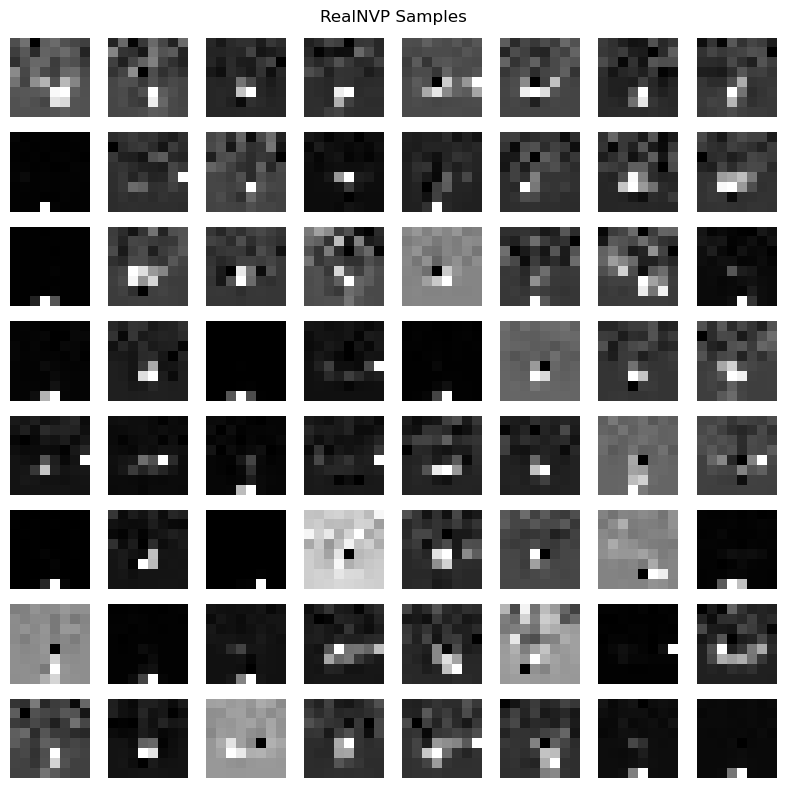


Training MAF flow...


Epoch 1/10: 100%|██████████| 469/469 [00:06<00:00, 75.34it/s] 


[Epoch 1] avg NLL = -92.9314


Epoch 2/10: 100%|██████████| 469/469 [00:05<00:00, 85.05it/s] 


[Epoch 2] avg NLL = -134.7660


Epoch 3/10: 100%|██████████| 469/469 [00:05<00:00, 89.71it/s] 


[Epoch 3] avg NLL = -144.4282


Epoch 4/10: 100%|██████████| 469/469 [00:05<00:00, 84.10it/s] 


[Epoch 4] avg NLL = -149.0691


Epoch 5/10: 100%|██████████| 469/469 [00:05<00:00, 84.96it/s] 


[Epoch 5] avg NLL = -152.2092


Epoch 6/10: 100%|██████████| 469/469 [00:05<00:00, 87.76it/s] 


[Epoch 6] avg NLL = -154.2167


Epoch 7/10: 100%|██████████| 469/469 [00:05<00:00, 89.22it/s] 


[Epoch 7] avg NLL = -155.9313


Epoch 8/10: 100%|██████████| 469/469 [00:05<00:00, 88.41it/s] 


[Epoch 8] avg NLL = -157.2789


Epoch 9/10: 100%|██████████| 469/469 [00:05<00:00, 89.78it/s] 


[Epoch 9] avg NLL = -158.5485


Epoch 10/10: 100%|██████████| 469/469 [00:05<00:00, 88.07it/s] 

[Epoch 10] avg NLL = -159.2995


MAF: Test avg log-likelihood = 156.8187


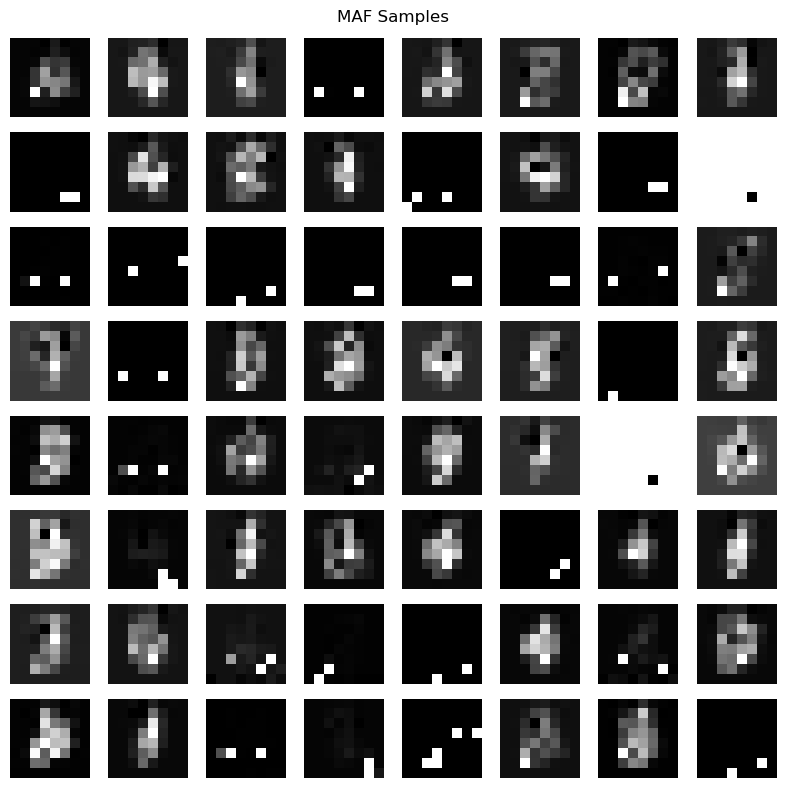

In [4]:


realnvp_model = RealNVP(input_dim=input_dim, hidden_dim=256, num_flows=4).to(device)
optimizer_rnvp = optim.Adam(realnvp_model.parameters(), lr=1e-3)
print("\nTraining RealNVP flow...")
train_flow(realnvp_model, train_loader, optimizer_rnvp, epochs=10)
test_log_prob_rnvp = evaluate_flow(realnvp_model, test_loader)
print(f"RealNVP: Test avg log-likelihood = {test_log_prob_rnvp:.4f}")
plot_samples(realnvp_model, n=8, title="RealNVP Samples")

maf_model = MAF(input_dim=input_dim, hidden_dim=256, num_flows=4).to(device)
optimizer_maf = optim.Adam(maf_model.parameters(), lr=1e-3)
print("\nTraining MAF flow...")
train_flow(maf_model, train_loader, optimizer_maf, epochs=10)
test_log_prob_maf = evaluate_flow(maf_model, test_loader)
print(f"MAF: Test avg log-likelihood = {test_log_prob_maf:.4f}")
plot_samples(maf_model, n=8, title="MAF Samples")
